In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings

warnings.filterwarnings("ignore")
os.chdir("../")

### read in all trades files and concate to one dataframe
from analysis import single_trade_files_to_one
single_trade_files_to_one().to_csv("historic_data/trades.csv")

### transform trades to usable profits dataframe
from analysis import format_trades_df, get_trade_count, calculate_profits
nft_trades = pd.read_csv("historic_data/trades.csv", low_memory=False)
nft_trades.pipe(format_trades_df).pipe(get_trade_count).pipe(calculate_profits).to_csv("historic_data/profits.csv")

In [33]:
import pandas as pd
from analysis import format_trades_df

In [53]:
trades = (
    pd.read_csv("historic_data/trades.csv", low_memory=False)
    .pipe(format_trades_df)
    .rename(columns={"NFT": "collection"})
)

In [3]:
nft_trades = pd.read_csv("historic_data/profits.csv", low_memory=False).set_index(
    ["nft_id", "trade_no"]
)
nft_trades["holding_period"] = pd.to_timedelta(nft_trades["holding_period"]).dt.days
nft_trades["sell_date"] = pd.to_datetime(nft_trades["sell_date"])
nft_trades["purchase_date"] = pd.to_datetime(nft_trades["purchase_date"])
nft_trades = nft_trades[nft_trades["profit_eth"] < 100]

In [5]:
nft_trades.head()

,,purchase_date,sell_date,holding_period,purchase_price_eth,sell_price_eth,profit_eth,purchase_price_usd,sell_price_usd,profit_usd,collection,from_address,to_address,purchase_hash,sell_hash
nft_id,trade_no,,,,,,,,,,,,,,
0xmons.xyz_103,1,2021-03-14,2021-08-01,140,6.00,5.000,-0.166667,11092.14,12782.05,0.152352,0xmons.xyz,0xfaf1031b02a994b80f12cc1ee4c0dcebbb946aa0,0x73ffce54ce7d21397a7932d9bc2a7e013ff30902,0xb4f8ec6ac9cd76de994c2912923ea09e0094be165913...,0x8a3fb6eec565e1f997881ea2b40bd778f21cf3f50fd8...
0xmons.xyz_118,1,2021-04-01,2021-12-04,247,7.99,12.000,0.501877,15721.68,49491.12,2.147954,0xmons.xyz,0x2117c37a65ad3c0489682386f7d81d4c6d08b3c8,0x947e1bbcbf8a67a9f7a393adf93179baaf0cccdc,0xa8cf0256bfcf5359365bd360f94cd6f76ba52c0b2053...,0xbccbf4cae59258731825c74cf7cad7243663732bfb77...
0xmons.xyz_126,1,2021-03-11,2021-08-07,149,5.55,7.770,0.400000,10140.18,24572.08,1.423239,0xmons.xyz,0xfaf1031b02a994b80f12cc1ee4c0dcebbb946aa0,0xd6d7ea4833f22edbed3dbd3d71adf3cdd8e36a01,0xaf9ca732b6ee7f0814705b68e814ce5e2e30d534ae8e...,0xb0c5c0bdd560e2c7cfac59029e705496cf4bb575b38e...
0xmons.xyz_127,1,2022-01-01,2022-02-12,42,21.00,19.069,-0.091952,79101.54,55649.83,-0.296476,0xmons.xyz,0x7260f7927a25949c15b7c4cbcf936510bf34c81b,0xb96a4bc4ae0bad1043feb96147fc18b17176b138,0xebb2398cdbdc822e695b4fafc8cf8604c18a609cef81...,0x7438a5d06720f8f25008807513476862965a7e2374d5...
0xmons.xyz_129,1,2021-02-20,2021-09-17,209,9.99,21.000,1.102102,19132.05,71375.22,2.730662,0xmons.xyz,0x11df180d9bdbe90fa51898b3d59959549d589426,0x7ce06dfb89aadec277f34fc575b3d735c593354e,0x2524b8a284df2f40fa885a071a4ad8e1cb515803d114...,0xa340d0c3b80a77b1d4de8beaeb17565dbd7e3eeefa84...


In [5]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.cluster import KMeans

#### Plot count of trades ditributed per date

In [46]:
nft_trades.loc[("BoredApeYachtClub_2087", 1)].sell_hash

'0xc9c4bbcd74fa83e9b15666c8827e4c37e28457ab7097f00c7674a612613fdbf4'

In [58]:
trades[["date", "price_usd", "collection"]].groupby(["date", "collection"]).sum()

price_usd
date       collection                  
2019-04-08 Autoglyphs            923.41
2019-04-09 Autoglyphs            387.86
2019-04-10 Autoglyphs            296.98
2019-04-11 Autoglyphs            644.44
2019-04-14 Autoglyphs            335.67
...                                 ...
2022-10-04 The Surreals          128.57
           Tubby Cats            337.09
           Women Rise             68.04
           Women and Weapons     492.90
           YOLO                   74.45

[19007 rows x 1 columns]

In [95]:
collection_sum = (
    nft_trades[["sell_date", "profit_usd", "collection"]]
    .pivot_table(columns="collection", index="sell_date", values="profit_usd", aggfunc="mean")
    .fillna(0)
)
#collection_sum.loc["Total", :] = collection_sum.sum(axis=0)
#collection_sum.loc[:, "Total"] = collection_sum.sum(axis=1)

In [96]:
collection_sum

collection,0xmons.xyz,10KTF,3Landers,8SIAN,AIMoonbirds,AVASTAR Token,Anatomy Science Ape Club,ArtAI,Async Art,Autoglyphs,...,Tubby Cats,Voxies,Waifus,Weirdo Ghost Gang,Women Rise,Women and Weapons,WonderPals,YOLO,inbetweeners,merge.
sell_date,,,,,,,,,,,,,,,,,,,,,
2019-06-06,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.024844,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2019-06-11,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.807771,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2019-08-01,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.274838,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2019-10-24,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.342220,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2019-12-25,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.554381,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-30,0.0,-0.215556,-0.547767,-0.887057,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,-0.270683,0.000000,-0.442405,0.0,-0.177560,-0.426913,-0.323583
2022-10-01,0.0,0.004934,-0.571839,0.477433,-0.286574,0.247569,-0.482446,-0.868874,0.0,0.000000,...,-0.924778,0.0,0.000000,0.000000,-0.522553,0.165637,0.0,-0.216095,-0.072524,1.482332
2022-10-02,0.0,0.114473,-0.631004,0.469376,-0.786837,-0.482230,-0.259702,0.000000,0.0,0.000000,...,-0.826509,0.0,0.000000,-0.531002,0.522319,-0.491781,0.0,-0.137234,-0.333919,-0.065474


In [99]:
collection_sum_rel = (
    nft_trades[["sell_date", "profit_usd", "collection"]]
    .pivot_table(columns="collection", index="sell_date", values="profit_usd", aggfunc="sum")
    .fillna(0)
).div(collection_sum_rel.sum(axis=1), axis=0)

In [104]:
df = (collection_sum_rel * collection_sum).dropna().loc[:, "Total"] = collection_sum.sum(axis=1)

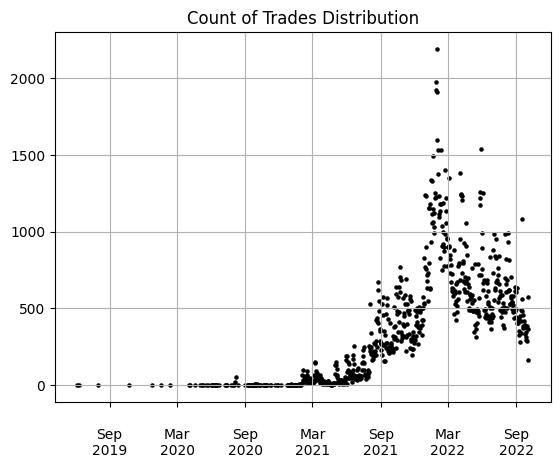

In [6]:
nft_trades["sell_date"] = pd.to_datetime(nft_trades["sell_date"])

plot_df = (
    nft_trades[["sell_date", "profit_usd"]]
    .groupby("sell_date")
    .count()
    .rename(columns={"profit_usd": "Count of Trades"})
    .loc["2019-01-01":]
    .reset_index()
)

ax = plot_df.plot.scatter(
    x="sell_date",
    y="Count of Trades",
    # c="Cluster",
    color="black",
    grid=True,
    xlabel="",
    marker=".",
    ylabel="",
    title="Count of Trades Distribution",
)
ax.xaxis.set_major_locator(mdates.MonthLocator([3, 9]))
ax.xaxis.set_major_formatter(mdates.DateFormatter("\n%b\n%Y"))
plt.show()

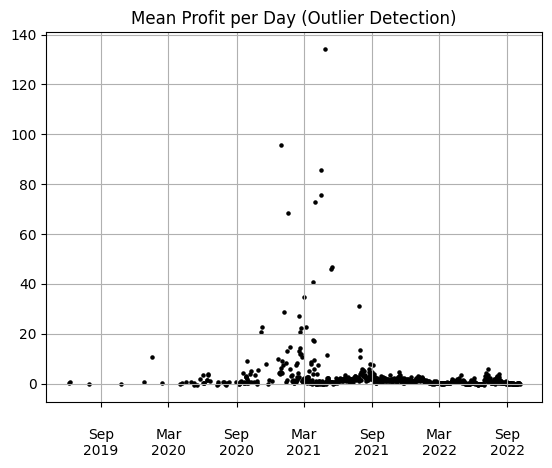

In [7]:
nft_trades["sell_date"] = pd.to_datetime(nft_trades["sell_date"])
ax = (
    nft_trades[["sell_date", "profit_usd"]]
    .groupby("sell_date")
    .mean()
    .rename(columns={"profit_usd": "Count of Trades"})
    .loc["2019-01-01":]
    .reset_index()
    .plot.scatter(
        x="sell_date",
        y="Count of Trades",
        grid=True,
        marker=".",
        color="black",
        ylabel="",
        xlabel="",
        title="Mean Profit per Day (Outlier Detection)",
    )
)
ax.xaxis.set_major_locator(mdates.MonthLocator([3, 9]))
ax.xaxis.set_major_formatter(mdates.DateFormatter("\n%b\n%Y"))
plt.show()

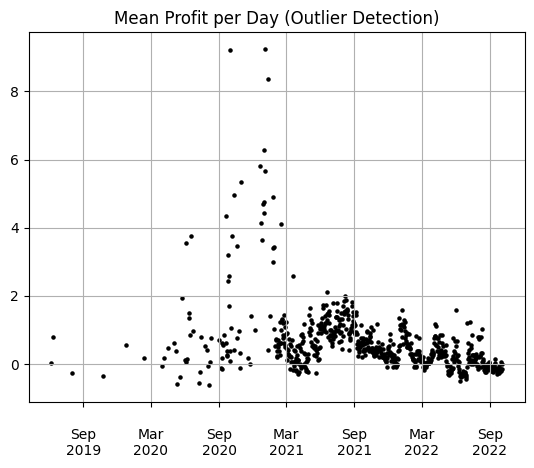

In [8]:
# show only profits below 100x
nft_trades = nft_trades[nft_trades["profit_usd"] < 10]
nft_trades["sell_date"] = pd.to_datetime(nft_trades["sell_date"])
ax = (
    nft_trades[["sell_date", "profit_usd"]]
    .groupby("sell_date")
    .mean()
    .rename(columns={"profit_usd": "Count of Trades"})
    .loc["2019-01-01":]
    .reset_index()
    .plot.scatter(
        x="sell_date",
        y="Count of Trades",
        grid=True,
        marker=".",
        color="black",
        ylabel="",
        xlabel="",
        title="Mean Profit per Day (Outlier Detection)",
    )
)
ax.xaxis.set_major_locator(mdates.MonthLocator([3, 9]))
ax.xaxis.set_major_formatter(mdates.DateFormatter("\n%b\n%Y"))
plt.show()

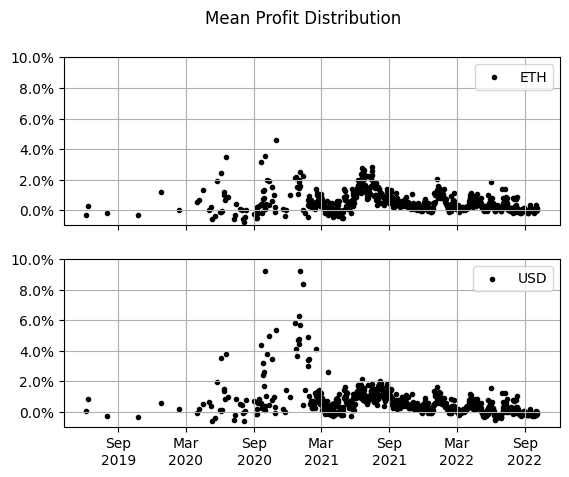

In [9]:
# show only profits below 100x
# nft_trades = nft_trades[nft_trades["profit_eth"]]
nft_trades["sell_date"] = pd.to_datetime(nft_trades["sell_date"])
nft_trades_plot_prepped = (
    nft_trades[["sell_date", "profit_eth", "profit_usd"]]
    .groupby("sell_date")
    .mean()
    .loc["2019-01-01":]
    .reset_index()
)

fig, (ax1, ax2) = plt.subplots(2)

fig.suptitle("Mean Profit Distribution")

y_pred = KMeans(4)
y_pred.fit(nft_trades_plot_prepped[["profit_eth", "profit_usd"]])
nft_trades_plot_prepped["Cluster"] = y_pred.labels_

ax1.scatter(
    x=nft_trades_plot_prepped["sell_date"],
    y=nft_trades_plot_prepped["profit_eth"],
    marker=".",
    color="black"
    # c=nft_trades_plot_prepped["Cluster"]
)
ax1.legend(["ETH"])

ax2.scatter(
    x=nft_trades_plot_prepped["sell_date"],
    y=nft_trades_plot_prepped["profit_usd"],
    marker=".",
    color="black"
    # c=nft_trades_plot_prepped["Cluster"]
)
ax2.legend(["USD"])

for ax in fig.get_axes():
    ax.label_outer()
    ax.grid()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.xaxis.set_major_locator(mdates.MonthLocator([3, 9]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
    ax.set_ylim(-1, 10)

plt.show()

In [10]:
nft_trades_outlier_removed = nft_trades[nft_trades["profit_eth"] < 10]

<AxesSubplot: ylabel='Frequency'>

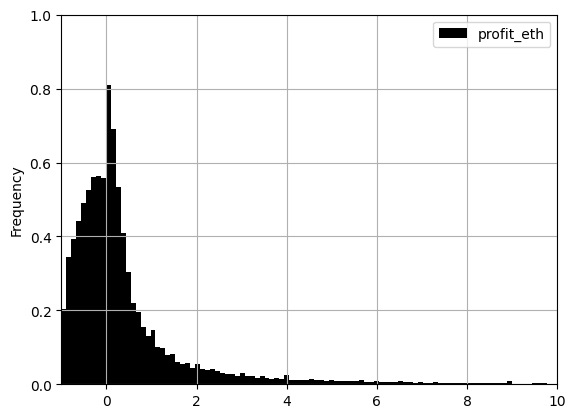

In [11]:
plot_df = nft_trades_outlier_removed["profit_eth"]

plot_df.plot.hist(
    bins=100,
    density=True,
    ylim=(0, 1),
    xlim=(-1, 10),
    legend=True,
    grid=True,
    color="black",
)

<AxesSubplot: ylabel='Frequency'>

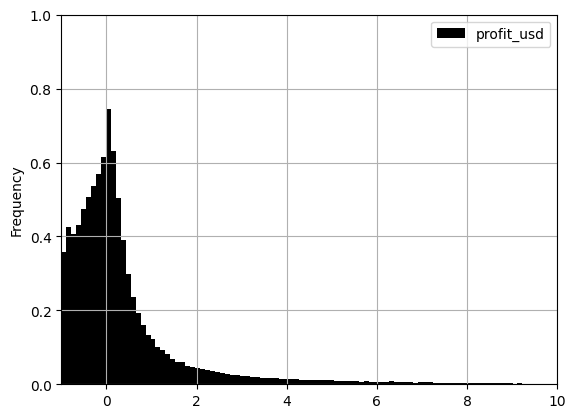

In [12]:
nft_trades_outlier_removed["profit_usd"].plot.hist(
    bins=100,
    density=True,
    ylim=(0, 1),
    xlim=(-1, 10),
    legend=True,
    grid=True,
    color="black",
)

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import kmeans_plusplus
from sklearn.datasets import make_blobs

# Generate sample data
n_samples = 4000
n_components = 4

X, y_true = make_blobs(
    n_samples=n_samples, centers=n_components, cluster_std=0.60, random_state=0
)
X = X[:, ::-1]

In [14]:
def get_return_per_eth(nft_trades, min_eth, max_eth):
    nft_trades_outlier_removed = nft_trades[
        (nft_trades["purchase_price_eth"] < max_eth)
        & (nft_trades["purchase_price_eth"] > min_eth)
    ].reset_index()[["purchase_price_eth", "profit_usd"]]
    y_pred = KMeans(5)
    y_pred.fit(nft_trades_outlier_removed)
    nft_trades_outlier_removed["Cluster"] = y_pred.labels_
    nft_trades_outlier_removed.plot.scatter(
        x="purchase_price_eth",
        y="profit_usd",
        xlabel="ETH",
        rot=("horizontal"),
        c="Cluster",
        ylabel="Average Return: "
        + str(round(nft_trades_outlier_removed["profit_usd"].mean() * 100, 1))
        + "%",
        marker=".",
        title="Average NFT Return"
        + " for ETH Price Range "
        + str(min_eth)
        + " - "
        + str(max_eth),
    )
    plt.axhline(y=0, color="red", alpha=0.5)
    plt.axhline(
        y=nft_trades_outlier_removed["profit_usd"].mean(), color="green", alpha=1
    )
    plt.grid()
    plt.show()

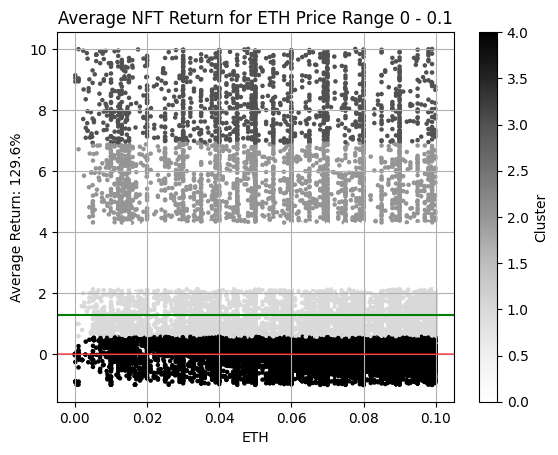

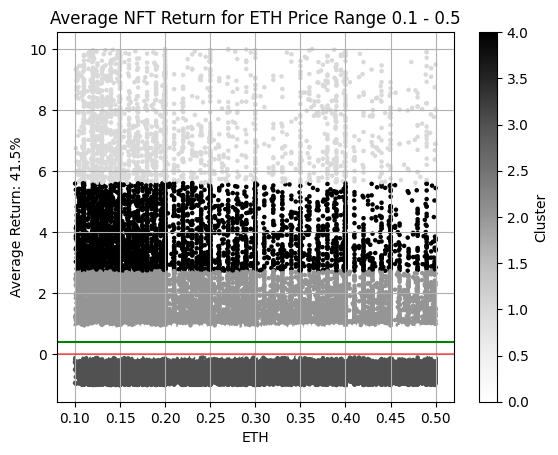

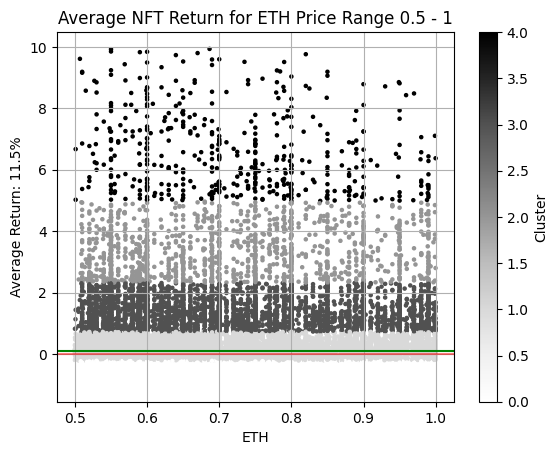

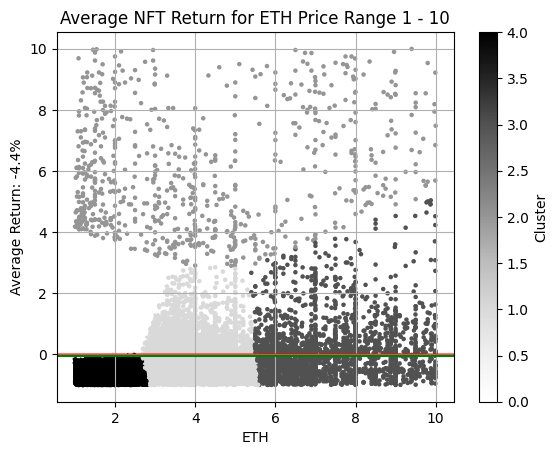

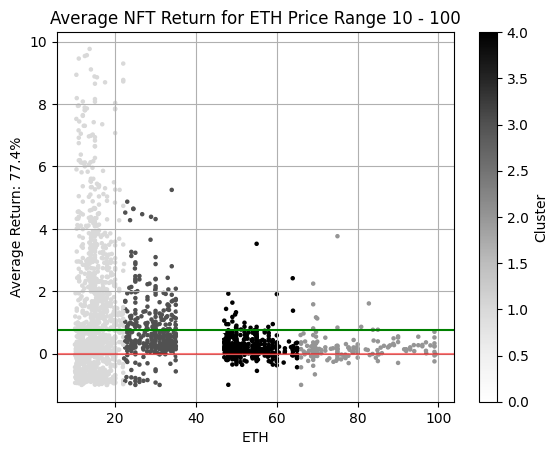

In [15]:
a = 0
for i in [0.1, 0.5, 1, 10, 100]:
    get_return_per_eth(nft_trades, a, i)
    a = i

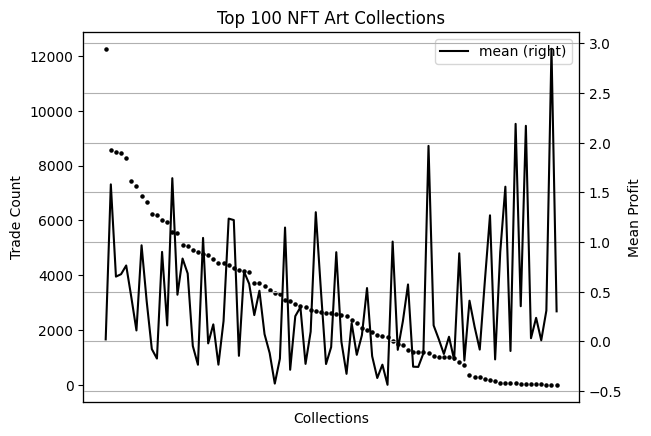

In [16]:
address_grouped = (
    nft_trades[["collection", "profit_usd"]]
    .groupby("collection")
    .agg(["min", "max", "sum", "count", "mean"])
    .round(4)["profit_usd"]
    .sort_values("count", ascending=False)
    .reset_index()
    .head(100)
)

ax = address_grouped.plot.scatter(
    x="collection",
    y="count",
    marker=".",
    color="black",
    legend=True,
    ylabel="Trade Count",
    xlabel="Collections",
)

ax1 = ax.twinx()

address_grouped.plot.line(
    x="collection",
    y="mean",
    xticks=[],
    xlabel="Collections",
    color="black",
    ylabel="Mean Profit",
    title="Top 100 NFT Art Collections",
    legend=True,
    secondary_y=True,
    ax=ax1,
)
plt.grid()

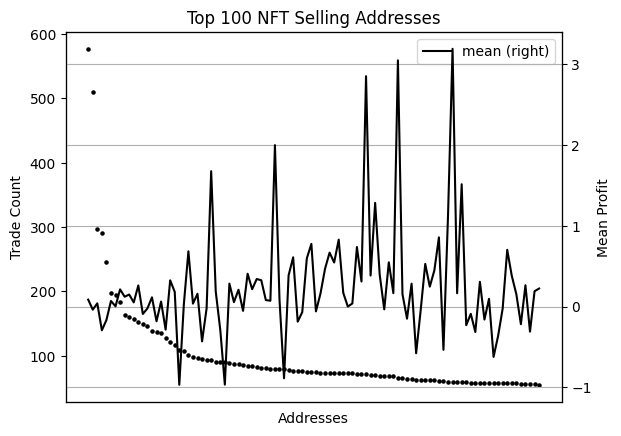

In [17]:
address_grouped = (
    nft_trades[["from_address", "profit_usd"]]
    .groupby("from_address")
    .agg(["min", "max", "sum", "count", "mean"])
    .round(4)["profit_usd"]
    .sort_values("count", ascending=False)
    .reset_index()
    .head(100)
)

ax = address_grouped.plot.scatter(
    x="from_address",
    y="count",
    marker=".",
    color="black",
    legend=True,
    ylabel="Trade Count",
    xlabel="Addresses",
)

ax1 = ax.twinx()

address_grouped.plot.line(
    x="from_address",
    y="mean",
    color="black",
    xticks=[],
    xlabel="Addresses",
    ylabel="Mean Profit",
    title="Top 100 NFT Selling Addresses",
    legend=True,
    secondary_y=True,
    ax=ax1,
)
plt.grid()

<AxesSubplot: title={'center': 'Profit per Holding Period'}, xlabel='Holding Period', ylabel='Mean Profit'>

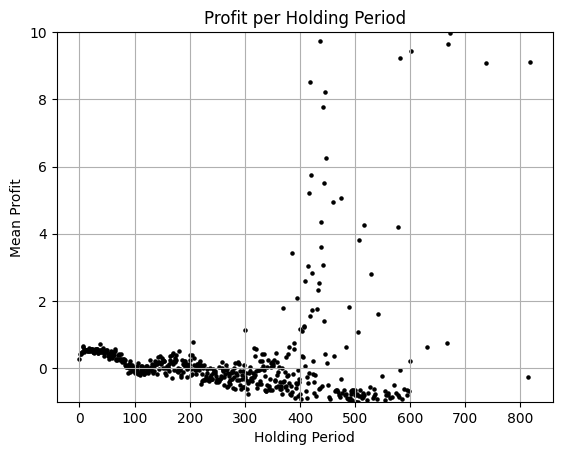

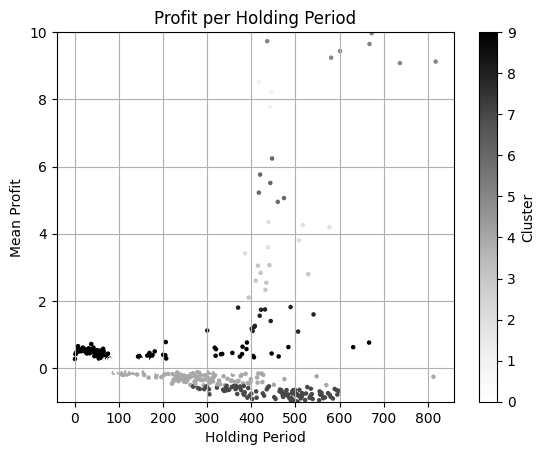

In [22]:
plot_df = (
    nft_trades[["holding_period", "profit_usd"]]
    .groupby("holding_period")
    .agg(["min", "max", "sum", "count", "mean"])
    .round(4)["profit_usd"]
    .reset_index()
)
y_pred = KMeans(10)
y_pred.fit(plot_df[["mean"]])
plot_df["Cluster"] = y_pred.labels_
plot_df.plot.scatter(
    x="holding_period",
    y="mean",
    xlabel="Holding Period",
    ylabel="Mean Profit",
    title="Profit per Holding Period",
    color="black",
    grid=True,
    ylim=[-1, 10],
    marker=".",
)
plot_df.plot.scatter(
    x="holding_period",
    y="mean",
    c="Cluster",
    xlabel="Holding Period",
    ylabel="Mean Profit",
    title="Profit per Holding Period",
    grid=True,
    ylim=[-1, 10],
    marker=".",
)

#### ToDo:

- Liquidität
- Erwerbbarkeit
- Handlichkeit der Wallets (Usability)
- Erwartete Rendite vs Vola
- Steuern
- Kosten Gas Fees --> always below 0.001 USD
- Diversifikation innerhalb NFTs -> Korrelationsmatrix

In [4]:
# Correlation
nft_trades.corr()

,holding_period,purchase_price_eth,sell_price_eth,profit_eth,purchase_price_usd,sell_price_usd,profit_usd
holding_period,1.000000,0.030818,0.077356,0.061711,0.028407,0.075083,0.110831
purchase_price_eth,0.030818,1.000000,0.717252,-0.025291,0.979934,0.716770,-0.009376
sell_price_eth,0.077356,0.717252,1.000000,0.239982,0.695693,0.980194,0.244795
profit_eth,0.061711,-0.025291,0.239982,1.000000,-0.024072,0.237391,0.676843
purchase_price_usd,0.028407,0.979934,0.695693,-0.024072,1.000000,0.703533,-0.013053
sell_price_usd,0.075083,0.716770,0.980194,0.237391,0.703533,1.000000,0.231871
profit_usd,0.110831,-0.009376,0.244795,0.676843,-0.013053,0.231871,1.000000


# Get Collections for Appendix

In [8]:
collections = nft_trades.collection.unique()

In [26]:
df = pd.DataFrame({1: collections[:45], 2: collections[44:]})

In [27]:
df[2] = df[2].shift(-1)

In [38]:
df.to_latex()

"\\begin{tabular}{lll}\n\\toprule\n{} &                                                 1 &                                         2 \\\\\n\\midrule\n0  &                                        0xmons.xyz &                                 Killer GF \\\\\n1  &                                             10KTF &                         Kitty Crypto Gang \\\\\n2  &                                          3Landers &                   KnownOriginDigitalAsset \\\\\n3  &                                             8SIAN &                                Lil Heroes \\\\\n4  &                                       AIMoonbirds &                            Lives of Asuna \\\\\n5  &                                     AVASTAR Token &                                Lost Poets \\\\\n6  &                          Anatomy Science Ape Club &  MAX PAIN AND FRENS OPEN EDITION BY XCOPY \\\\\n7  &                                             ArtAI &                     MOAR by Joan Cornella \\\\\n8  &     